In [16]:
import warnings
import numpy as np
import pandas as pd
import scipy
import scipy.io
import re

import sklearn.decomposition

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from matplotlib import cm
import seaborn as sns

In [17]:
pd.set_option('display.max_rows', 100)

-----------

In [18]:
datadir = './data/kinsler-2020-preprocessed-data/'

In [46]:
figdir  = './figures/'

----------

## Load variants info

In [20]:
variantsInfo = pd.read_csv(datadir+'variants.csv')

In [21]:
variantsInfo

,additional_muts,barcode,class,gene,ploidy,type,barcode_sequence,barcode_GCratio
0,TIP1-upstream_point_variant; YKR012C-upstream_...,53,Diploid,Diploid,Diploid,Diploid,AACGTAAGTCTAAACGTATTTGAGAA,0.307692
1,SEH1-missense_variant; ZIP1-missense_variant; ...,151,PKA,IRA1,Haploid,stop_gained,TCCATAATTGGGAATTGGATTTTGGC,0.384615
2,NotSequenced,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,TTAATAAACAAGAAACGGGTTGTGGA,0.346154
3,None,273,PKA,IRA1,Haploid,frameshift_variant,TCACTAAGAAGGAAGTCCATTATTAC,0.346154
4,NotSequenced,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,AGCCAAAAAAGTAATATTTTTGACCA,0.269231
...,...,...,...,...,...,...,...,...
544,None,9000106,PKA,IRA1,Haploid,stop_gained,NaN,NaN
545,None,9000107,PKA,IRA1,Haploid,stop_gained,NaN,NaN
546,None,9000108,PKA,IRA1,Haploid,stop_gained,NaN,NaN
547,None,9000109,PKA,IRA1,Haploid,stop_gained,NaN,NaN


----------

## Load fitness data (without bias correction)

In [22]:
matlab_data_orig = scipy.io.loadmat('./data/tikhonov-matlab-data/dataOriginal.mat')['dataOriginal'][0]
matlab_fitness_orig = pd.DataFrame(np.nan, index=variantsInfo.index, columns=[])
for a in range(len(matlab_data_orig)):
    assay = matlab_data_orig[a][0][0].replace("_", "")
    fitness_table = matlab_data_orig[a][6]
    if(fitness_table.ndim == 2):
        for r in range(fitness_table.shape[-1]):
            R = r+1
            fitness_rep = fitness_table[:, r]
            matlab_fitness_orig[f"{assay}-R{R}"] = fitness_rep            
    elif(fitness_table.ndim == 1):
        R = 1
        fitness_rep = fitness_table
        for tidx in range(fitness_rep.shape[-1]):
            T = tidx+1
            matlab_fitness_orig[f"{assay}-R{R}"] = fitness_rep 

In [23]:
# Update assays from the matlab data to match naming used in this pipeline:
matlabAssays_studyAssays = {'EC23-R1': 'EC23-R1',
                            'EC23-R2': 'EC23-R2',
                            'EC23-R3': 'EC23-R3',
                            'EC21-R1': 'EC21-R1',
                            'EC21-R2': 'EC21-R2',
                            'EC21-R3': 'EC21-R3',
                            'EC20-R1': 'EC20-R1',
                            'EC20-R2': 'EC20-R2',
                            'EC20-R3': 'EC20-R3',
                            'EC18-R1': 'EC18-R1',
                            'EC18-R2': 'EC18-R2',
                            'EC18-R3': 'EC18-R3',
                            'EC13-R1': 'EC13-R1',
                            'EC13-R2': 'EC13-R2',
                            'EC13-R3': 'EC13-R3',
                            'EC3-R1': 'EC3-R1',
                            'EC3-R2': 'EC3-R2',
                            'EC3-R3': 'EC3-R3',
                            'BBBaffle-R1': 'Baffled-R1',
                            'BBBaffle-R2': 'Baffled-R2',
                            'BB1.4%Gluc-R1': '1.4%Gluc-R1',
                            'BB1.4%Gluc-R2': '1.4%Gluc-R2',
                            '1.6%-R1': '1.6%Gluc-R1',
                            '1.6%-R2': '1.6%Gluc-R2',
                            'BB1.8%Gluc-R1': '1.8%Gluc-R1',
                            'BB1.8%Gluc-R2': '1.8%Gluc-R2',
                            'BB0.5%Raf-R1': '0.5%Raf-R1',
                            'BB0.5%Raf-R2': '0.5%Raf-R2',
                            'BBSucRaf-R1': '1.5%Suc1%Raf-R1',
                            'BB0.2MKCl-R1': '0.2MKCl-R1',
                            'BB0.5MKCl-R1': '0.5MKCl-R1',
                            'BBM3-R1': 'M3-R1',
                            'BBM3-R2': 'M3-R2',
                            'BBM3-R3': 'M3-R3',
                            'BBM3-R4': 'M3-R4' }
matlab_fitness_orig.columns = [matlabAssays_studyAssays[label] for label in matlab_fitness_orig.columns]

# Reorder columns using the order of the dict above, for cosmetic reasons:
matlab_fitness_orig = matlab_fitness_orig[matlabAssays_studyAssays.values()]

In [24]:
fitnesses_orig = {'all': matlab_fitness_orig}
fitnesses_orig['all']

,EC23-R1,EC23-R2,EC23-R3,EC21-R1,EC21-R2,EC21-R3,EC20-R1,EC20-R2,EC20-R3,EC18-R1,...,1.8%Gluc-R2,0.5%Raf-R1,0.5%Raf-R2,1.5%Suc1%Raf-R1,0.2MKCl-R1,0.5MKCl-R1,M3-R1,M3-R2,M3-R3,M3-R4
0,0.446288,0.442715,0.508718,0.391507,0.292392,0.466504,0.643813,0.653056,0.358831,0.300910,...,0.338726,0.294374,0.353559,0.304162,0.470639,0.245911,0.368635,0.330942,0.358192,0.420460
1,1.130618,1.040206,1.043425,0.940915,0.787281,0.896370,1.309610,1.247050,0.744539,1.182547,...,1.008221,0.974286,1.016687,0.482674,0.172367,-0.774228,1.002198,1.101857,0.991140,1.086478
2,0.399510,0.441574,0.492217,0.437467,0.393807,0.464081,0.473809,0.545172,0.382108,0.146688,...,0.369651,0.311854,0.377479,0.265127,0.537421,0.297015,0.372118,0.317200,0.411006,0.436189
3,0.938699,0.855982,0.913954,0.836916,0.761214,0.819050,1.027565,0.995736,0.701604,1.018290,...,0.788884,0.753173,0.826970,0.363117,0.332213,-0.907117,0.810455,0.871940,0.770927,0.902999
4,0.879600,0.746139,0.792107,0.782276,0.773783,0.672287,0.887488,0.783406,0.615062,1.000424,...,0.627716,0.556169,0.633964,0.251137,0.335197,-0.469658,0.677556,0.823690,0.744128,0.738584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.718033,0.651173,0.687912,0.181976,-1.081652,NaN,0.890693,0.894264,0.775088,0.792026
545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.776054,0.812344,0.866786,0.305180,-1.067523,NaN,0.871803,0.810014,0.512426,0.604196
546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.751477,0.693784,0.727240,0.228826,-1.046799,NaN,0.831445,0.900135,0.796181,0.797824


----------

## Determine neutral groups

In [25]:
assays_forNeutralGrouping = [col for col in fitnesses_orig['all'].dropna().columns]

##### Store a separate dataframe of fitness values for each group being considered

In [26]:
groupby = 'gene'
for group in ['Diploid', 'PDE2', 'GPB2']: 
    fitnesses_orig[group] = fitnesses_orig['all'].loc[variantsInfo[groupby] == group, assays_forNeutralGrouping]
    

##### Filter out variants and assays that have too much missing data

In [27]:
DROP_ROW_PCT_NAN = 0.2
DROP_COL_PCT_NAN = 0.2

for group in ['Diploid', 'PDE2', 'GPB2']: 
    fitnesses_orig[group] = fitnesses_orig[group].loc[(fitnesses_orig[group].isna().sum(axis=1) < int(DROP_ROW_PCT_NAN*len(fitnesses_orig[group].columns))), :]
    fitnesses_orig[group] = fitnesses_orig[group].loc[:, fitnesses_orig[group].isna().sum() < int(DROP_COL_PCT_NAN*len(fitnesses_orig[group]))]
    fitnesses_orig[group] = fitnesses_orig[group].dropna(axis=0)
    


#### Newer method (from 4/19 notebook) with nan filtering, outlier exclusion, and greedy energy clustering

In [28]:
np.random.seed(1)

In [29]:
def optimize_neutral_group_selection(fitnesses, OUTLIER_PERCENTILE, ENERGY_THRESHOLD, NUM_ENERGY_TRIALS=10, INIT_ENERGY_CLUSTER_SIZE=5): # DROP_ROW_PCT_NAN=0.2, DROP_COL_PCT_NAN=0.2,
    
    # Covariance matrix
    covariance  = np.cov(fitnesses , rowvar=False)
    # Covariance matrix power of -1
    covariance_pm1 = np.linalg.matrix_power(covariance, -1)
    # Center of group
    centroid = fitnesses.mean(axis=0).values
    
    # implemented using guide at https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3
    mahalanobis_distances = []
    for i, fitnesses_i in fitnesses.iterrows():
        d = (fitnesses_i.values - centroid).T.dot(covariance_pm1).dot(fitnesses_i.values - centroid)
        mahalanobis_distances.append(d)
    mahalanobis_distances = np.array(mahalanobis_distances)

    outlier_cutoff    = scipy.stats.chi2.ppf(OUTLIER_PERCENTILE, len(fitnesses.columns))
    fitnesses_inliers = fitnesses.loc[mahalanobis_distances < outlier_cutoff, :]

    #~~~~~~~~~~~~~~~~~~~

    bestCluster     = None
    bestClusterSize = 0
    bestTrial       = None
    bestEnergySum   = 0
    for cluster_trial in range(NUM_ENERGY_TRIALS):
        fitnesses_clustered   = fitnesses_inliers.sample(n=INIT_ENERGY_CLUSTER_SIZE) if len(fitnesses_inliers) > INIT_ENERGY_CLUSTER_SIZE else fitnesses_inliers
        fitnesses_unclustered = fitnesses_inliers.drop(fitnesses_clustered.index)
        #--------------
        clusterEnergies_alongBuildup = []
        fEpsilons_initialCluster = fitnesses_clustered - fitnesses_clustered.mean(axis=0)
        U_initialCluster, s_initialCluster, VT_initialCluster = np.linalg.svd( fEpsilons_initialCluster )                    
        mode_energies_initialCluster = s_initialCluster**2/(s_initialCluster**2).sum()
        mode1_energy_initialCluster  = mode_energies_initialCluster[0]
        clusterEnergies_alongBuildup.append(mode1_energy_initialCluster)
        #--------------
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            while(len(fitnesses_unclustered) > 0):
                variantIDs = []
                energies   = []
                for i, fitnesses_i in fitnesses_unclustered.iterrows():
                    variantIDs.append(i)
                    fitnesses_putativeCluster = fitnesses_clustered.append(fitnesses_i)
                    fEpsilons_putativeCluster = fitnesses_putativeCluster - fitnesses_putativeCluster.mean(axis=0)
                    U_putativeCluster, s_putativeCluster, VT_putativeCluster = np.linalg.svd( fEpsilons_putativeCluster )                    
                    mode_energies_putativeCluster = s_putativeCluster**2/(s_putativeCluster**2).sum()
                    mode1_energy_putativeCluster  = mode_energies_putativeCluster[0]
                    energies.append(mode1_energy_putativeCluster)
                energies = np.array(energies)
                #----------
                optVariant = variantIDs[np.argmax(energies)]
                fitnesses_clustered = fitnesses_clustered.append(fitnesses_unclustered.loc[optVariant])
                fitnesses_unclustered.drop(optVariant, inplace=True)
                fEpsilons_cluster   = fitnesses_clustered - fitnesses_clustered.mean(axis=0)
                #----------
                U_cluster, s_cluster, VT_cluster = np.linalg.svd( fEpsilons_cluster )                    
                mode_energies_cluster = s_cluster**2/(s_cluster**2).sum()
                mode1_energy_cluster  = mode_energies_cluster[0]
                clusterEnergies_alongBuildup.append(mode1_energy_cluster)
                #----------
                if(mode1_energy_cluster < ENERGY_THRESHOLD):
                    fitnesses_clustered = fitnesses_clustered[:-1] # drop last row, which pushed cluster past threshold
                    break
        #--------------
        clusterSize = len(fitnesses_clustered)
        if(clusterSize > bestClusterSize or (clusterSize == bestClusterSize and np.sum(clusterEnergies_alongBuildup) > bestEnergySum)):
            bestCluster     = fitnesses_clustered.copy()
            bestClusterSize = clusterSize
            bestTrial       = cluster_trial
            bestEnergySum   = np.sum(clusterEnergies_alongBuildup)
        print(f"\ttrial {cluster_trial}, cluster size {clusterSize}, * best cluster size:{bestClusterSize}/{len(fitnesses_inliers)} energysum:{bestEnergySum} in trial {bestTrial} *", end='\r')
    #------------------
    print(f"\t* best size {bestClusterSize}/{len(fitnesses_inliers)} in trial {bestTrial} *")
    
    #~~~~~~~~~~~~~~~~~~~

    fitnesses_putativeNeutrals = bestCluster
    mahalanobisDistances_all   = mahalanobis_distances

    return fitnesses_putativeNeutrals, mahalanobisDistances_all
    

In [30]:
fitnesses_putativeNeutrals = {}
mahalanobisDistances_allInGroup = {}

OUTLIER_PERCENTILE = 0.9
ENERGY_THRESHOLD   = 0.0

groupby = 'gene'
for group in ['Diploid', 'PDE2', 'GPB2']: 
    print(group)
    fitnesses_putativeNeutrals[group], mahalanobisDistances_allInGroup[group] = optimize_neutral_group_selection(fitnesses_orig[group], OUTLIER_PERCENTILE, ENERGY_THRESHOLD, NUM_ENERGY_TRIALS=10) # was 100
    

Diploid
	* best size 164/164 in trial 5 *t cluster size:164/164 energysum:124.43714148818307 in trial 5 *
PDE2
	* best size 11/11 in trial 7 *st cluster size:11/11 energysum:5.892779610032187 in trial 7 *
GPB2
	* best size 12/12 in trial 5 *st cluster size:12/12 energysum:7.555493252002165 in trial 5 *


-------
#### Hand-curate variants included in each neutral group returned by above process

In [31]:
controlGroupVariantIDs = {}

In [32]:
neutralGroups_numTrimVariants = {'Diploid': 5, 'PDE2': 1, 'GPB2': 0}

Diploid
PDE2
GPB2


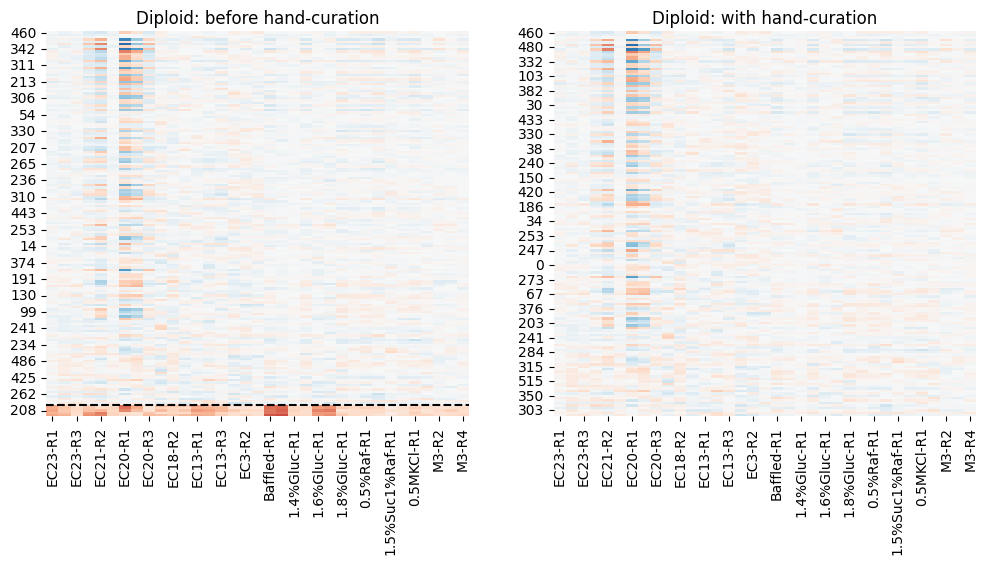

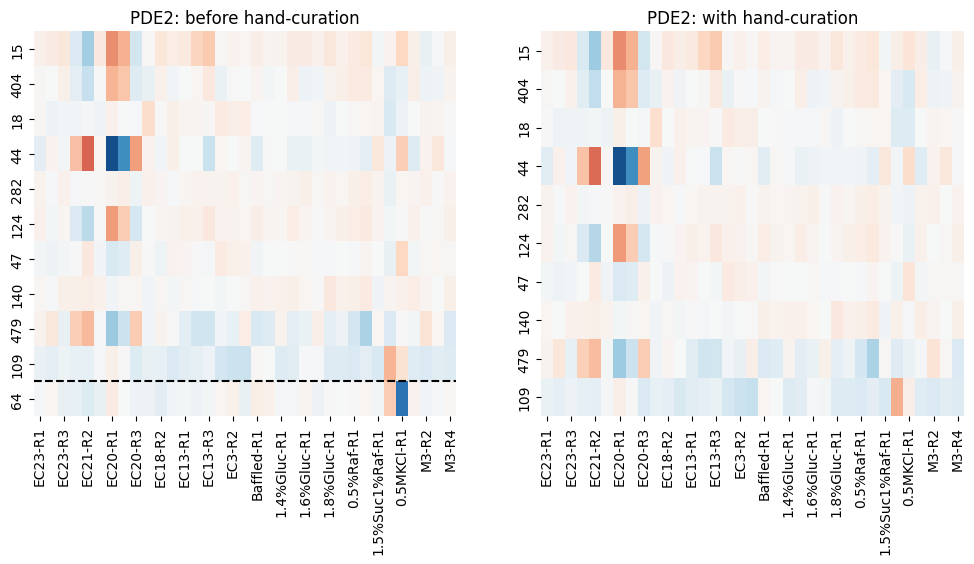

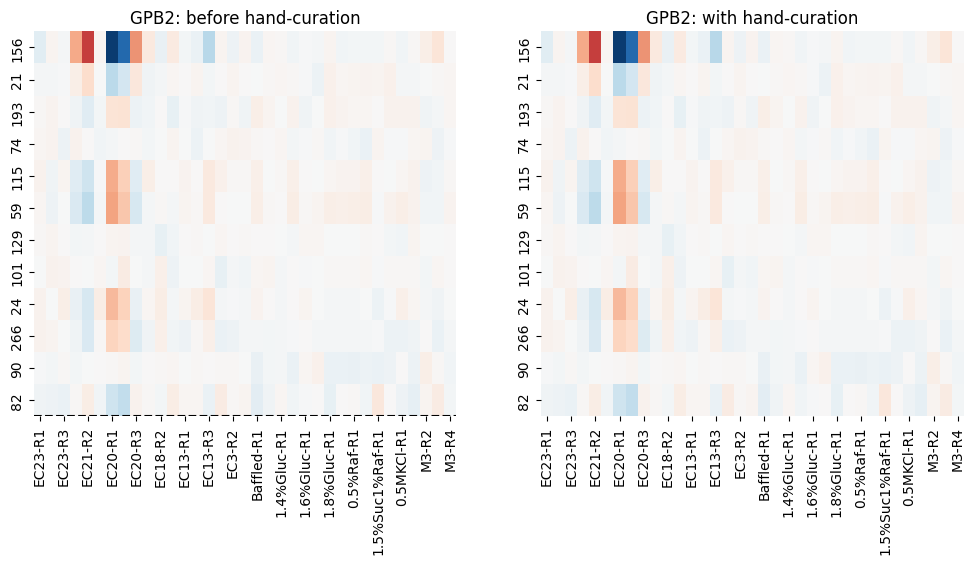

In [33]:
for group in fitnesses_putativeNeutrals:
    print(group)
    
    controlGroupVariantIDs[group] = fitnesses_putativeNeutrals[group].index.values[:] # -neutralGroups_numTrimVariants[group]
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    sns.heatmap(ax=ax[0], data=(fitnesses_orig['all'].loc[controlGroupVariantIDs[group]] - fitnesses_orig['all'].loc[controlGroupVariantIDs[group]].mean(axis=0)), cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar=False)
    ax[0].axhline(len(fitnesses_orig['all'].loc[controlGroupVariantIDs[group]]) - neutralGroups_numTrimVariants[group], color='k', ls='--')
    ax[0].set_title(f"{group}: before hand-curation")
    
    if(neutralGroups_numTrimVariants[group] > 0):
        controlGroupVariantIDs[group] = fitnesses_putativeNeutrals[group].index.values[:-neutralGroups_numTrimVariants[group]]
        sns.heatmap(ax=ax[1], data=(fitnesses_orig['all'].loc[controlGroupVariantIDs[group]] - fitnesses_orig['all'].loc[controlGroupVariantIDs[group]].mean(axis=0)), cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar=False)
        ax[1].set_title(f"{group}: with hand-curation")
    else:
        sns.heatmap(ax=ax[1], data=(fitnesses_orig['all'].loc[controlGroupVariantIDs[group]] - fitnesses_orig['all'].loc[controlGroupVariantIDs[group]].mean(axis=0)), cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar=False)
        ax[1].set_title(f"{group}: with hand-curation")
        
        

In [34]:
controlGroupVariantIDs

{'Diploid': array([460, 122, 343,  37,  88,  25, 480, 342, 228, 351, 198, 145, 332,
        278, 311, 294, 184, 483, 103, 385, 245, 213,  19, 449, 382, 134,
        190,  91, 306, 319,  30, 209, 256,  98, 254,  54, 433, 435, 297,
        226, 238, 321, 330,  78, 263, 175, 445, 136,  38, 207,  95, 399,
        196, 125, 240, 508, 265, 272, 119, 168, 150, 328, 473, 236, 398,
        354, 420,  92, 431, 391, 310, 172, 186, 235, 396, 295, 197, 443,
         34, 389,  69, 194, 388, 345, 253, 485, 304, 406, 377, 314, 247,
         14, 418,  39, 419, 309,   0, 152, 374, 276, 181, 362, 273, 392,
        403, 191, 349, 299,  67, 300, 520, 183, 130, 456, 376, 329, 417,
        164, 372,  99, 203, 261, 380, 307, 123, 219, 241, 414, 424, 430,
        422, 317, 284, 234, 326, 229, 246, 132, 315, 457, 486, 353, 271,
        383, 515, 286, 516, 425, 355, 341, 350, 492,  55,  51, 262, 402,
        303, 257, 367]),
 'PDE2': array([ 15, 404,  18,  44, 282, 124,  47, 140, 479, 109]),
 'GPB2': array([156,

In [35]:
variantsInfo['neutral_group'] = None
for group in controlGroupVariantIDs:
    variantsInfo.loc[controlGroupVariantIDs[group], 'neutral_group'] = group.capitalize() if group == 'other' else group

variantsInfo

,additional_muts,barcode,class,gene,ploidy,type,barcode_sequence,barcode_GCratio,neutral_group
0,TIP1-upstream_point_variant; YKR012C-upstream_...,53,Diploid,Diploid,Diploid,Diploid,AACGTAAGTCTAAACGTATTTGAGAA,0.307692,Diploid
1,SEH1-missense_variant; ZIP1-missense_variant; ...,151,PKA,IRA1,Haploid,stop_gained,TCCATAATTGGGAATTGGATTTTGGC,0.384615,None
2,NotSequenced,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,TTAATAAACAAGAAACGGGTTGTGGA,0.346154,None
3,None,273,PKA,IRA1,Haploid,frameshift_variant,TCACTAAGAAGGAAGTCCATTATTAC,0.346154,None
4,NotSequenced,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,AGCCAAAAAAGTAATATTTTTGACCA,0.269231,None
...,...,...,...,...,...,...,...,...,...
544,None,9000106,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None
545,None,9000107,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None
546,None,9000108,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None
547,None,9000109,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None


In [36]:
variantsInfo['control_set'] = (variantsInfo['neutral_group'] == 'Diploid')

----------

#### Save neutral groups and control set to file

In [37]:
variantsInfo.to_csv(datadir+'variants_withNeutralGroups.csv')
variantsInfo

,additional_muts,barcode,class,gene,ploidy,type,barcode_sequence,barcode_GCratio,neutral_group,control_set
0,TIP1-upstream_point_variant; YKR012C-upstream_...,53,Diploid,Diploid,Diploid,Diploid,AACGTAAGTCTAAACGTATTTGAGAA,0.307692,Diploid,True
1,SEH1-missense_variant; ZIP1-missense_variant; ...,151,PKA,IRA1,Haploid,stop_gained,TCCATAATTGGGAATTGGATTTTGGC,0.384615,None,False
2,NotSequenced,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,TTAATAAACAAGAAACGGGTTGTGGA,0.346154,None,False
3,None,273,PKA,IRA1,Haploid,frameshift_variant,TCACTAAGAAGGAAGTCCATTATTAC,0.346154,None,False
4,NotSequenced,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,AGCCAAAAAAGTAATATTTTTGACCA,0.269231,None,False
...,...,...,...,...,...,...,...,...,...,...
544,None,9000106,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None,False
545,None,9000107,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None,False
546,None,9000108,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None,False
547,None,9000109,PKA,IRA1,Haploid,stop_gained,NaN,NaN,None,False


-----

#### Generate SI figure of neutral groups' $\delta f$ matrices and SVD spectra

In [38]:
fitnesses_viz = {}

for group in ['Diploid', 'GPB2', 'PDE2']:
    
    variants_allInMutClass = fitnesses_orig[group].index.values
    
    variants_inControlSet = controlGroupVariantIDs[group] # 
    mahalanobisDistances_inControlSet = [mahalanobisDistances_allInGroup[group][np.where(variants_allInMutClass == i)][0] for i in variants_inControlSet]
    variants_inControlSet = [i for _, i in sorted(zip(mahalanobisDistances_inControlSet, variants_inControlSet))]

    variants_handExcluded = np.array([vid for vid in fitnesses_putativeNeutrals[group].index.values if (vid in fitnesses_putativeNeutrals[group].index.values and vid not in variants_inControlSet)])
    mahalanobisDistances_handExcluded = [mahalanobisDistances_allInGroup[group][np.where(variants_allInMutClass == i)][0] for i in variants_handExcluded]
    variants_handExcluded = [i for _, i in sorted(zip(mahalanobisDistances_handExcluded, variants_handExcluded))]

    variants_distOutliers = np.array([vid for vid in fitnesses_orig[group].index.values if (vid not in fitnesses_putativeNeutrals[group].index.values and vid not in variants_inControlSet)])
    mahalanobisDistances_distOutliers = [mahalanobisDistances_allInGroup[group][np.where(variants_allInMutClass == i)][0] for i in variants_distOutliers]
    variants_distOutliers = [i for _, i in sorted(zip(mahalanobisDistances_distOutliers, variants_distOutliers))]
    
    fitnesses_viz[group] = fitnesses_orig[group].loc[variants_inControlSet, :]

    

In [39]:
from matplotlib.gridspec import GridSpec

In [41]:
group_palette = sns.color_palette("Set2")

In [42]:
groups_colors = {'Diploid': group_palette[2], 'GPB2': group_palette[4], 'PDE2': group_palette[3]}

In [43]:
assay_relabels = {
'EC23': 'EC1',
'EC21': 'EC2',
'EC20': 'EC3',
'EC18': 'EC4',
'EC13': 'EC5',
'EC3': 'EC6',
'Baffled': 'Baffled',
'1.4%Gluc': '1.4% Gluc',
'1.6%Gluc': '1.6% Gluc',
'1.8%Gluc': '1.8% Gluc',
'0.5%Raf': '0.5% Raf',
'1.5%Suc1%Raf': '1.5% Suc, 1% Raf',
'0.2MKCl': '0.2M KCl',
'0.5MKCl': '0.5M KCl',
'M3': 'ECBB',
}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/d6/x4cngrp14359hts_5q3ccm1w0000gn/T/

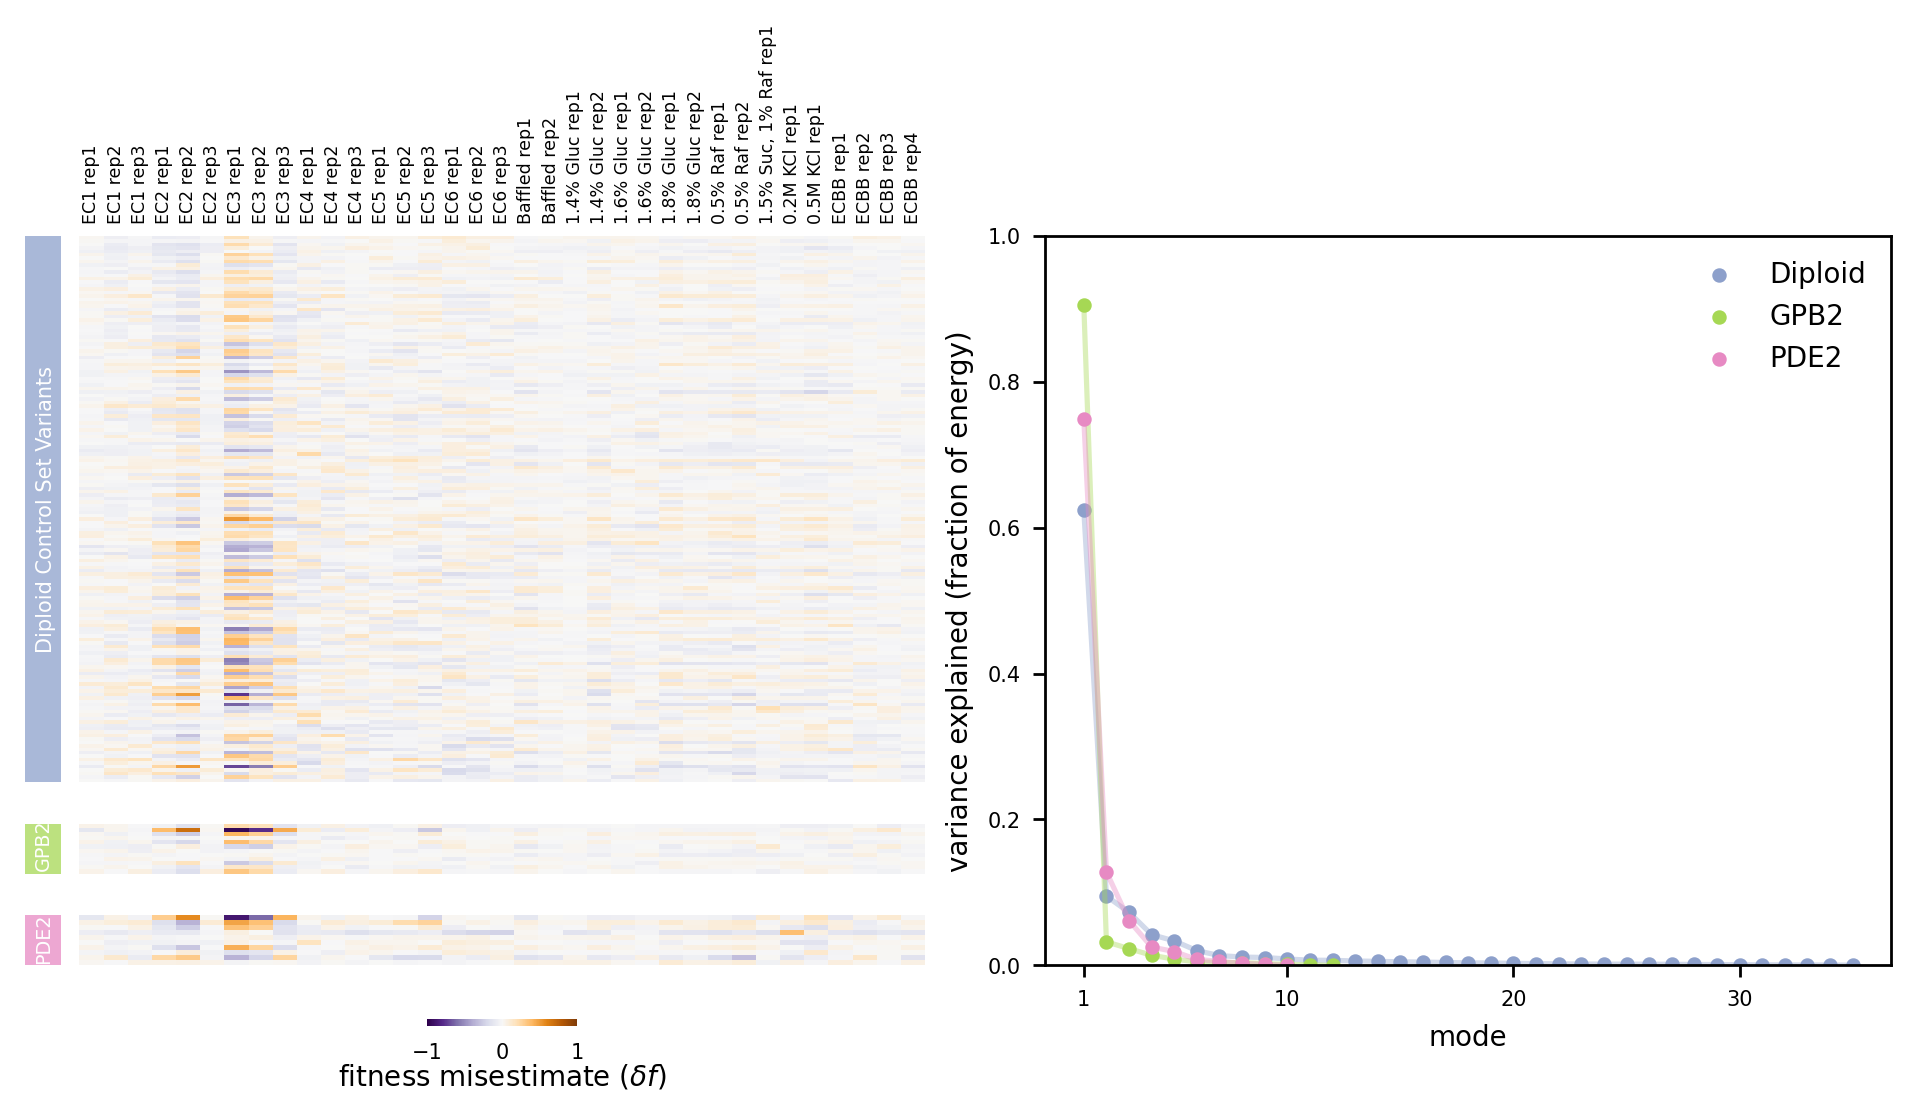

In [47]:
fig = plt.figure(constrained_layout=False, figsize=(7.5, 4.5), dpi=250)

gs = fig.add_gridspec(30, 2)

ax1 = fig.add_subplot(gs[0:24,   0])
ax2 = fig.add_subplot(gs[24:27,   0])
ax3 = fig.add_subplot(gs[27:,  0])
axSVD = fig.add_subplot(gs[:, 1])

###########################

for gidx, group in enumerate(['Diploid', 'GPB2', 'PDE2']):
    
    U_g, s_g, VT_g = np.linalg.svd( (fitnesses_viz[group] - fitnesses_viz[group].mean(axis=0)) ) 
    variance_explained = (s_g**2)/np.sum(s_g**2)
    # print(s_g)
    # print(variance_explained)
    
    axSVD.plot(range(len(s_g)), variance_explained, zorder=gidx, c=groups_colors[group], alpha=0.4)
    axSVD.scatter(range(len(s_g)), variance_explained, s=10, zorder=gidx, c=groups_colors[group], label=group)
    axSVD.legend(frameon=False, prop={'size': 8})
    
axSVD.set_xlabel('mode', fontsize=8)
# axSVD.set_xlim(xmin=0)
axSVD.set_xticks([1-1, 10-1, 20-1, 30-1])
axSVD.set_xticklabels([1, 10, 20, 30], fontsize=6)
axSVD.set_ylabel('variance explained (fraction of energy)', fontsize=8)
axSVD.set_ylim([0, 1])
axSVD.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axSVD.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=6)


###########################

sns.heatmap(ax=ax1, data=(fitnesses_viz['Diploid'] - fitnesses_viz['Diploid'].mean(axis=0)), cmap='PuOr_r', center=0, vmin=-1, vmax=1, cbar=False)
ax1.set_yticks([])
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.set_xticks(np.array(range(len(fitnesses_viz['Diploid'].columns)))+0.5, length=0)
ax1.tick_params('x', length=0, width=0, which='major')
ax1.set_xticklabels([assay_relabels[col.split('-')[0]]+' '+f"rep{col[-1]}" for col in fitnesses_viz['Diploid'].columns], rotation=90, fontsize=5)
ax1.add_patch(mpatches.Rectangle(xy=(-2.25, 0), width=1.5, height=len(fitnesses_viz['Diploid']), fc=groups_colors['Diploid'], alpha=0.75, ec='w', lw=0.0, clip_on=False, zorder=-1))
ax1.text(-0.95, len(fitnesses_viz['Diploid'])/2, "Diploid Control Set Variants", c='w', verticalalignment='center', horizontalalignment='right', fontsize=6, rotation=90, zorder=100)

sns.heatmap(ax=ax2, data=(fitnesses_viz['GPB2'] - fitnesses_viz['GPB2'].mean(axis=0)), cmap='PuOr_r', center=0, vmin=-1, vmax=1, cbar=False)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.add_patch(mpatches.Rectangle(xy=(-2.25, 0), width=1.5, height=len(fitnesses_viz['GPB2']), fc=groups_colors['GPB2'], alpha=0.75, ec='w', lw=0.0, clip_on=False, zorder=-1))
ax2.text(-1.1, len(fitnesses_viz['GPB2'])/2-1, "GPB2", c='w', verticalalignment='center', horizontalalignment='right', fontsize=5.5, rotation=90, zorder=100)

sns.heatmap(ax=ax3, data=(fitnesses_viz['PDE2'] - fitnesses_viz['PDE2'].mean(axis=0)), cmap='PuOr_r', center=0, vmin=-1, vmax=1, cbar=True, cbar_kws=dict(use_gridspec=False, location="bottom", pad=-0.75))
ax3.set_yticks([])
ax3.set_xticks([])
ax3.add_patch(mpatches.Rectangle(xy=(-2.25, 0), width=1.5, height=len(fitnesses_viz['PDE2']), fc=groups_colors['PDE2'], alpha=0.75, ec='w', lw=0.0, clip_on=False, zorder=-1))
ax3.text(-1.1, len(fitnesses_viz['PDE2'])/2-0.5, "PDE2", c='w', verticalalignment='center', horizontalalignment='right', fontsize=5.5, rotation=90, zorder=100)

cbar = ax3.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=6, width=0, length=1)
cbar.set_label(label='fitness misestimate ($\\delta f$)', size=8, labelpad=0)

fig.savefig(figdir+'figSI_neutralgroups-svd.png', dpi=250)